# Imports and Data Preparation

In [151]:
from MASH import MASH
import numpy as np
import pandas as pd
import test_manifold_algorithms as tma
from SPUD import SPUD
from rfgap import RFGAP
import matplotlib.pyplot as plt


#DC is short for data class
dc = tma.test_manifold_algorithms(csv_file="seeds.csv", split = "even", percent_of_anchors= [0.2], verbose = 2, random_state= 10)


 
 
---------------------------       Initalizing class with seeds.csv data       ---------------------------

Spliting the data evenly
Split A features shape: (199, 4)
Split B Features shape (199, 3)
MDS initialized with 3 components
The knn values are: (2, 6, 10, 14, 18, 22, 26, 30, 34, 38)


In [152]:
#Create a normalize function
def normalize_0_to_1(value):
    """Normalizes the value to be between 0 and 1 and resets infinite values."""

    #Scale it and check to ensure no devision by 0
    if np.max(value[~np.isinf(value)]) != 0:

      value = (value - value.min()) / (value[~np.isinf(value)].max() - value.min()) 

    #Reset inf values
    value[np.isinf(value)] = 1

    return value

In [153]:
def replace_with_ones(data):
    data = np.array(data)
    return np.ones(shape = data.shape)

# Preparing and Working though RF GAP

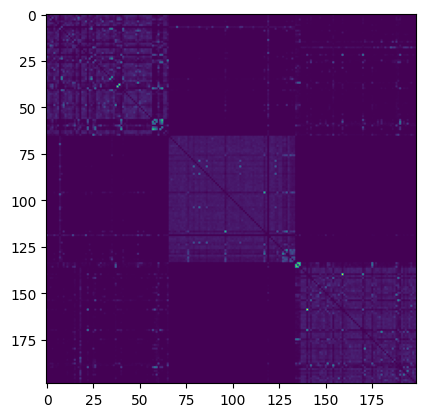

In [154]:
#Initilize Class
rf_class = RFGAP(prediction_type="classification", y=dc.labels, prox_method="rfgap", matrix_type= "dense", triangular=False, non_zero_diagonal=False)

#Fit it for Data A
rf_class.fit(dc.split_A, y = dc.labels)

#Get promities
dataA = rf_class.get_proximities()

#Show them
plt.imshow(rf_class.get_proximities())

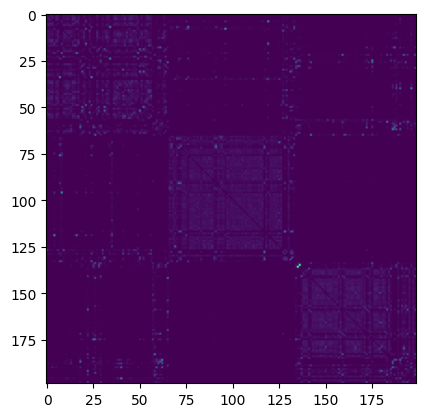

In [155]:
#Fit it for Class B
rf_class.fit(dc.split_B, y = dc.labels)

#Get promities
dataB = rf_class.get_proximities()

#Show them
plt.imshow(rf_class.get_proximities())

In [156]:
#Initialize SPUD Class
spud_class = SPUD(distance_measure= normalize_0_to_1, knn = 5, operation = 1.0, IDC = 1, verbose = 3)

#Fit SPUD
spud_class.fit(dataA = dataA, dataB = dataB, known_anchors = dc.anchors[:10])

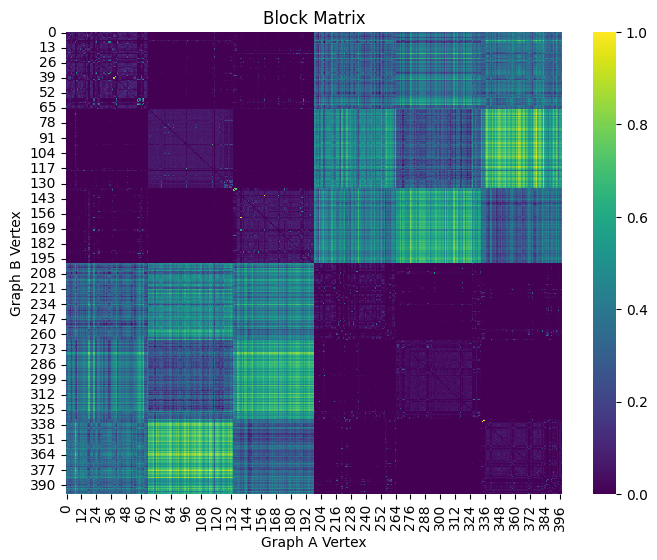

In [157]:
spud_class.plot_heat_map()

Cross Embedding: 0.3316582914572864
FOSCTTM: 0.2352970884573622


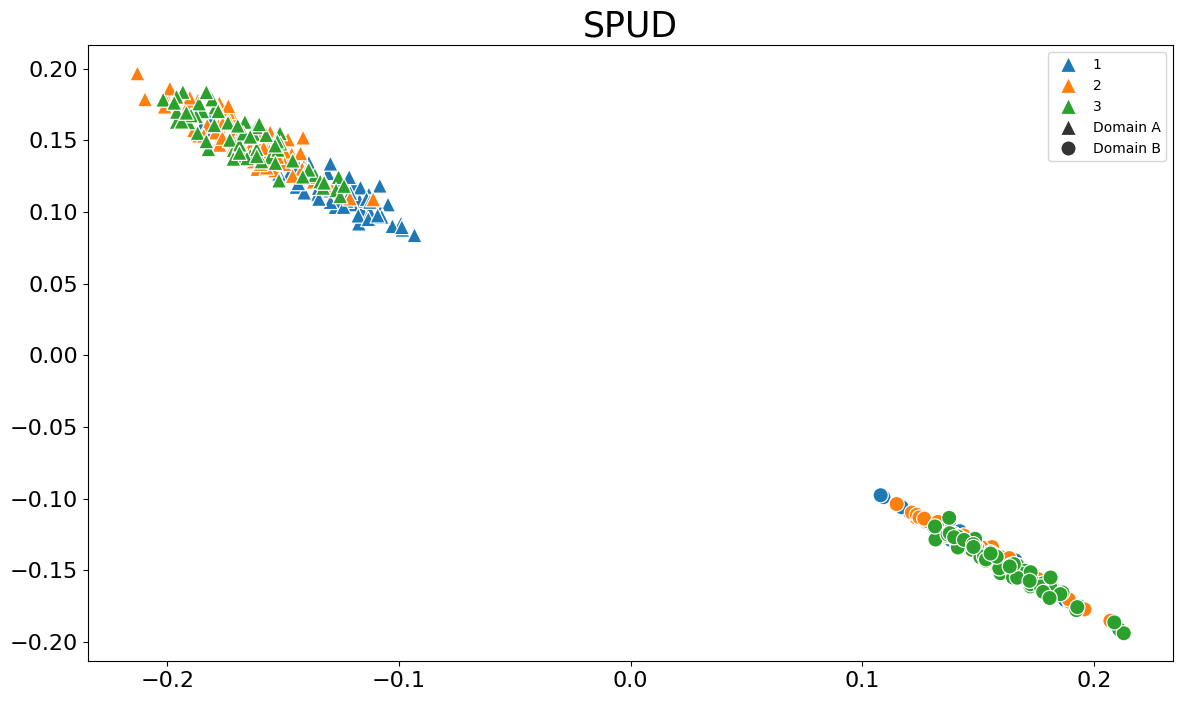

In [158]:
spud_class.plot_emb(labels = dc.labels_doubled, show_lines = False, show_anchors = False)